# Random Forest (Classification)

This notebook demonstrates the implementation of a random forest algorithm (ensemble-based **method**) in classification tasks. For a complete description of the random forest algorithm, see **this README**; for an overview of the decision trees on which it is based, see **this README** and **this example file**.

This notebook contains several **sections for each one - fill them in!!**

### Library Imports
This section imports the libraries **and modules** required to run the random forest algorithm. The **following dependencies are required**

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.randomforest import *
from rice_ml.postprocess.classificationpost import *

### Data Loading & Cleaning
The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms due to its **clear-cut features/simplicity/not too large/other benefits**. It has been chosen **because it is simple for classification** and requires several preprocessing steps, including **handling missing values**, which **showcase the preprocessing modules/package**. This dataset contains the following feature data for 344 penguins:
- Species: **fill this in, three species - 'Adelie' 'Chinstrap' 'Gentoo'**
- Island: **fill this in - 'Biscoe' 'Dream' 'Torgersen'**
- Bill Length (mm): continuous values, measuring bill length in millimeters
- Bill Depth (mm): continuous values, measuring bill depth in millimeters
- Flipper Length (mm): continuous values, measuring flipper length in millimeters
- Body Mass (g): continuous values, measuring body mass in grams
- Sex: **binary male/female**

**we drop some features** 
**This section covers the actual loading of the data; the data is loaded using `sns.load_dataset("penguins")`. Explanation here!! why those features?? encode using pandas uniques. Then cleaned using preprocessing - dropped missing values, identified outliers with z-scoring and dropped, dropped duplicates, z-scored the feature data for standardization**. This **notebook attempts to predict species. This section is copied in KNN as well, given that they use very similar algorithms. it's also used in decision tree**

In [55]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "sex", 
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]
penguin_features.loc[:, 'sex'], uniques = pd.factorize(penguin_features['sex'])
display(penguin_features)

,sex,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,1,39.5,17.4,186.0,3800.0
2,1,40.3,18.0,195.0,3250.0
3,-1,NaN,NaN,NaN,NaN
4,1,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,-1,NaN,NaN,NaN,NaN
340,1,46.8,14.3,215.0,4850.0
341,0,50.4,15.7,222.0,5750.0
342,1,45.2,14.8,212.0,5200.0


The dataset contains **some missing values (e.g., row 4)** and **may contain outliers or duplicates**. To **put the data in a usable format**, we apply a series of preprocessing **algorithms**, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [56]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
penguin_features_cleaned = penguin_features_cleaned[~np.any(penguin_features_cleaned < 0, axis=1)]
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[0.00e+00 3.91e+01 1.87e+01 1.81e+02 3.75e+03]
 [1.00e+00 3.95e+01 1.74e+01 1.86e+02 3.80e+03]
 [1.00e+00 4.03e+01 1.80e+01 1.95e+02 3.25e+03]
 [1.00e+00 3.67e+01 1.93e+01 1.93e+02 3.45e+03]
 [0.00e+00 3.93e+01 2.06e+01 1.90e+02 3.65e+03]]


**Explain - dropped -1 as well**

In [57]:
# Creating two arrays
penguin_sex = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for island (first five entries): \n {penguin_sex[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for island (first five entries): 
 [0. 1. 1. 1. 0.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


### Data Visualization

**TODO: fill this in!!**

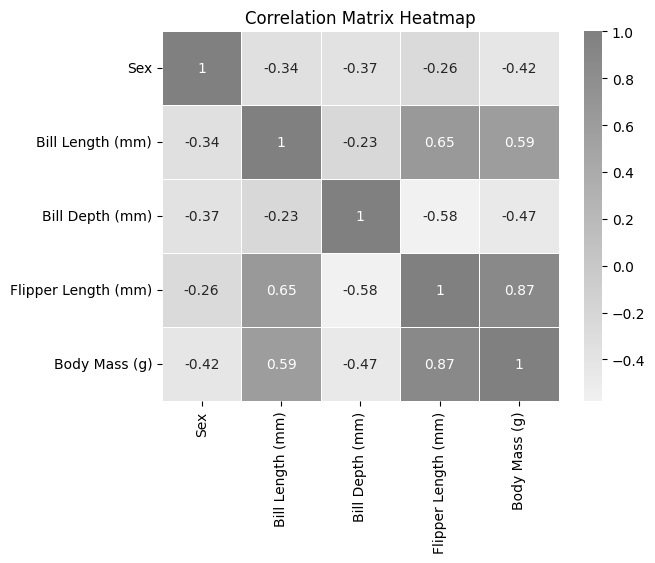

In [58]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Sex', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Body mass and bill depth are both somewhat correlated with sex, **so these will be used as the features in the random forest classifier**. The relationship between the three variables is visualized below using a two-dimensional plot of body mass and bill depth, with sex color-coded.

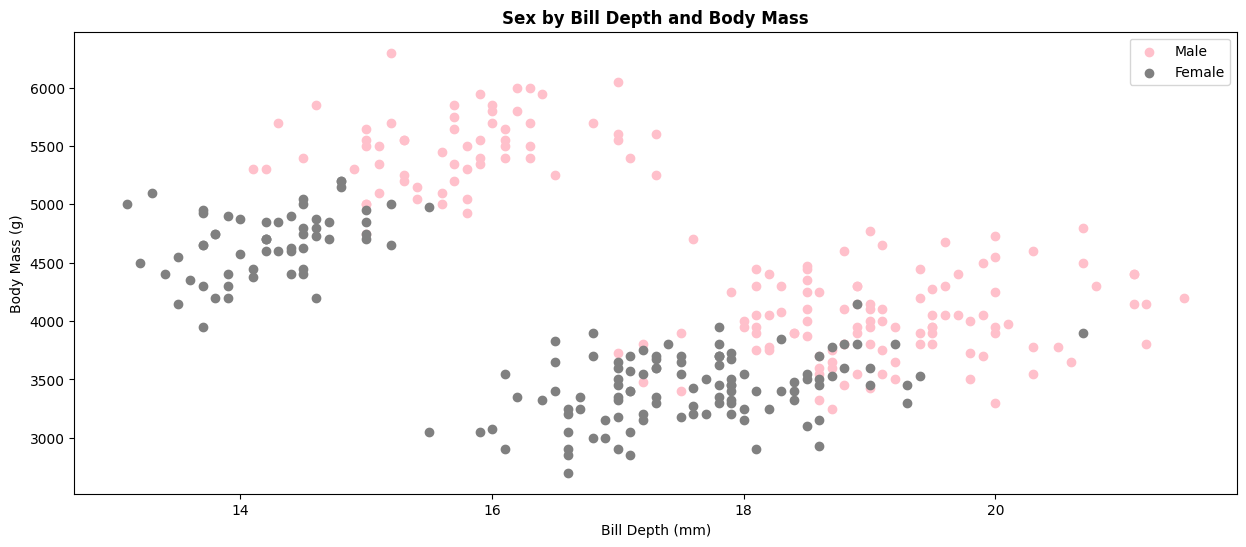

In [65]:
# Plotting bill depth and body mass, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}

plt.figure(figsize = (15, 6))
for sex in np.unique(penguin_sex):
    mask = (penguin_sex == sex)
    plt.scatter(penguin_feature_data[mask, 1], penguin_feature_data[mask, 3], label = sex, color = colors[sex])
    
plt.legend(['Male', 'Female'])
plt.title("Sex by Bill Depth and Body Mass", fontweight = 'bold')
plt.xlabel("Bill Depth (mm)")
plt.ylabel("Body Mass (g)")

plt.show()

**elaborate on the plot**

### Random Forest Implementation (2 Features)

This section **implements a basic random forest algorithm for the two identified features to attempt to classify sex**. **elaborate!!** 

**To avoid skewing results with different feature values**, we standardize the feature data **by calculating zscores** using the `z_score_standardize` **module** from the preprocessing package. This ensures that **no feature dominates/overrides the other ones** by **making them all the same scale**. The z-score equation used is **this!!**

In [67]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [1, 3]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[ 0.7807321  -0.56847478]
 [ 0.11958397 -0.50628618]
 [ 0.42472926 -1.1903608 ]
 [ 1.0858774  -0.94160639]
 [ 1.74702554 -0.69285199]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. **stratification/0.3 test_array size**. There are **342 samples in **the cleaned dataset**, so the training array should have 240 samples and the testing should have 102 - wrong!**

In [72]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_sex, stratify = penguin_sex)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (233, 2)
Shape of training targets: (233,)
Shape of testing array: (100, 2)
Shape of testing targets: (100,)


We then **initialize and fit a random forest classifier - elaborate!!**

In [ ]:
# Fitting the model
forest = random_forest(100, 'classification')
forest.fit(train_array, train_targets)

# Predicting sex based on testing data
prediction = tree.predict(test_array)

In [70]:
# Splitting the data into training and testing arrays
penguin_feature_data_normal_all_feat = z_score_standardize(penguin_feature_data)
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_all_feat, penguin_sex, stratify = penguin_sex)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (233, 4)
Shape of training targets: (233,)
Shape of testing array: (100, 4)
Shape of testing targets: (100,)


In [61]:
# Fitting the model
tree_mult = random_forest(100, 'classification')
tree_mult.fit(train_array_mult, train_targets_mult)

# Predicting species based on testing data
prediction_mult = tree_mult.prediction(test_array_mult)

In [62]:
accuracy_score(prediction_mult, test_targets_mult)

0.9